# The Capacitated Vehicle Routing Problem

A short example of using Gurobi to model and solve the CRVP

> Vehicle routing problems are inherently intractable: the length of time it takes to solve them grows exponentially with the size of the problem. For sufficiently large problems, it could take OR-tools (or any other routing software) years to find the optimal solution.. 

In [17]:
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()




In [3]:
#or tools imports
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

## Parameters

In [4]:
N_PATIENTS = 15
SEED = 101

## Patient Geographic Location

In [5]:
#random number generator for synthetic data.
rand_gen = RandomState(seed=SEED)

#n_patients = 1 so we include the depot
x_coords = rand_gen.random(size=N_PATIENTS+1) * 200
y_coords = rand_gen.random(size=N_PATIENTS+1) * 100

coords = [[x, y] for x, y in zip(x_coords, y_coords)]

In [6]:
def plot_patient_coordinates(x_coords, y_coords):
    '''
    Plot a simple scatter of coordinates. 
    Depot is red, customers are blue
    
    Paramters:
    x_coords: array-like
        x coordinates for each patient. element 0 = depot.
        
    y_coords: array-like
        y coordinates for each patient. element 0 = depot
    '''
    plt.plot(x_coords[0], y_coords[0], c='r', marker='^')
    #plt.scatter(x_coords[1:], y_coords[1:], c='b')
    
    for i in range(1, len(x_coords[1:])):
        x = x_coords[i]
        y = y_coords[i]
        plt.plot(x, y, 'b*')
        plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)
    
    plt.xlim((0, 220))
    plt.ylim((0, 120))
    plt.show()

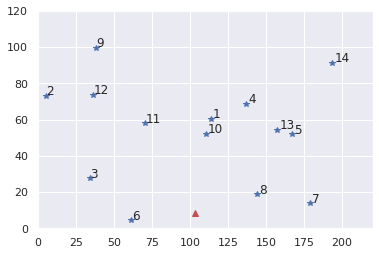

In [7]:
#visualise
plot_patient_coordinates(x_coords, y_coords)

## Approaches to 'solving' the CVRP

* Formulation as a Mixed Integer Programme (MIP) and use of a optimisation solver
* **Heuristic solution**.  E.g. using Iterated Local Search.

## Solution via meta-heuristic

In [ ]:
#Iterated Local Search - multiple runs of Ordinary Decent 2Opt
objective = SimpleTSPObjective(matrix)
local_search = OrdinaryDecent2OptNew(objective, tour)
runner = IteratedLocalSearch(objective, local_search, maximisation=False)
n = 20
print("\nRunning Iterated Local Search using Ordinary Decent 2-Opt ({} runs)..."\
      .format(n))
runner.run(n)

In [8]:
def create_data_model(coords):
    data = {}
    data['distance_matrix'] = gen_matrix(np.array(coords))
    data['num_vehicles'] = round(N_PATIENTS / 4) 
    data['depot'] = 0
    data['vehicle_capacities'] = [4 for i in range(data['num_vehicles'])]
    data['demands'] = [1 for i in range(N_PATIENTS)]
    return data

In [13]:
"""Vehicles Routing Problem (VRP)."""

from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    max_route_distance = 0
    total_distance = 0
    routes = []
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route = []
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            route.append(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
            total_distance += route_distance
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
        routes.append(route)
    print('Maximum of the route distances: {}m'.format(max_route_distance))
    print('total distance: {}m'.format(total_distance))
    return routes


def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model(coords)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)


    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(
        demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    #time limit
    search_parameters.time_limit.seconds = 30
    
    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)


    # Print solution on console.
    if solution:
        routes = print_solution(data, manager, routing, solution)
        
    print(routes)


In [14]:
main()

Route for vehicle 0:
 0 ->  2 ->  1 -> 0
Distance of the route: 0m

Route for vehicle 1:
 0 ->  6 ->  5 ->  4 ->  3 -> 0
Distance of the route: 0m

Route for vehicle 2:
 0 ->  10 ->  9 ->  8 ->  7 -> 0
Distance of the route: 0m

Route for vehicle 3:
 0 ->  15 ->  14 ->  13 ->  12 ->  11 -> 0
Distance of the route: 0m

Maximum of the route distances: 0m
total distance: 0m
[[0, 2, 1], [0, 6, 5, 4, 3], [0, 10, 9, 8, 7], [0, 15, 14, 13, 12, 11]]


In [75]:
def plot_solution(x, instance):
    active_arcs = [a for a in instance['A'] if x[a].x == 1.00]
    xc = instance['x_coords']
    yc = instance['y_coords']
    
    for i, j in active_arcs:
        plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='green')
        plt.plot(xc[0], yc[0], c='r', marker='s')
        plt.scatter(xc[1:], yc[1:], c='b')

## Mixed Integer Programme (MIP) formulation

* The advantage of a mathematical forumulation of the problem is that we can use a modern solver like **Gurobi**.
* Gurobi is extremely powerful.  The downside is that a commerical tool and the source code is closed (but free to use in research).

$n$ is the number of patients

$N$ is the set of patients $\{1, 2, ..., n\}$

$V$ is the set of verticies (nodes) to visit. $V=\{0\}\cup N$

$A$ is the set of arcs (links) $A = \left\{ \left(i,j\right)  \in V^2 : i\neq j\right\}$

$c_{ij}$ is cost of travel over arc $(i,j)\in A$

$Q$ is the vehicle capacity (for ambulances this is an integer)

$q_i$ is the load represented by a patient (in our problem this always 1)



\begin{equation}
\begin{aligned}
       \text{min} &  \sum_{i=1}^{n} \sum_{j=1}^{n} c_{ij} x_{ij} \\
       \text{s.t.} & \sum_{i=1}^{n} x_{ij} = 1, & & j \in N, j \neq i \\
       &   \sum_{j=1}^{n} x_{ij} = 1, & & i \in N, i \neq j \\
       &  \text{if} \ x_{ij}=1 \ \Rightarrow \ u_i + q_j = u_j && i,j \in A : j\neq 0, i\neq 0 \\
       &  q_i \leq u_i \leq Q && i \in N \\
       &  x_{ij} \in \{0,1\} && i,j \in A
\end{aligned}
\end{equation}




In [11]:
def problem_instance(n_patients, vehicle_capacity, random_state=None):
    '''
    Create an instance of the CVRP in the formulation
    of a MIP.
    
    Parameters:
    ------
    n_patient: int
    vehicle_capacity: int
    random_state: int, optional (default=None)
    
    Returns:
    -----
        dict, keys = N, V, A, c, Q, q
    '''
    rand_gen = RandomState(seed=random_state)
    
    #n_patients = 1 so we include the depot
    x_coords = rand_gen.random(size=n_patients+1) * 200
    y_coords = rand_gen.random(size=n_patients+1) * 100
    
    N = np.arange(1, n_patients+1)
    V = np.arange(0, n_patients+1)
    A = [(i, j) for i in V for j in V if i != j]
    c = {(i, j): np.hypot(x_coords[i]-x_coords[j], y_coords[i]-y_coords[j]) 
     for i, j in A}
    Q = vehicle_capacity
    q = {i: 1 for i in N}
    return {'x_coords':x_coords, 'y_coords':y_coords, 
            'N':N, 'V':V, 'A':A, 'c':c, 'Q':Q, 'q':q}

In [12]:
def optimisation_model(instance):
    '''
    Create and return an istance of a gurobi optimisation
    model for solving the CVRP.
    
    Parameters:
    -------
    instance: dict
        problem instance for the CVRP
    '''
    mdl = Model('dialysis_transport')
    
    N = instance['N']
    V = instance['V']
    A = instance['A']
    c = instance['c']
    Q = instance['Q']
    q = instance['q']
        
    x = mdl.addVars(A, vtype=GRB.BINARY)
    u = mdl.addVars(N, vtype=GRB.CONTINUOUS)
    mdl.modelSense = GRB.MINIMIZE
    mdl.setObjective(quicksum(x[a]*instance['c'][a] for a in A))
    mdl.addConstrs(quicksum(x[i, j] for j in V if j != i) == 1 for i in N)
    mdl.addConstrs(quicksum(x[i, j] for i in V if i != j) == 1 for j in N)
    mdl.addConstrs((x[i, j] == 1) >> (u[i]+q[j] == u[j])
                   for i, j in A if i != 0 and j != 0)
    mdl.addConstrs(u[i] >= q[i] for i in N)
    mdl.addConstrs(u[i] <= Q for i in N)
    return mdl, x, u

In [19]:
def plot_solution(x, instance):
    active_arcs = [a for a in instance['A'] if x[a].x == 1.00]
    xc = instance['x_coords']
    yc = instance['y_coords']
    
    for i, j in active_arcs:
        plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='green')
        plt.plot(xc[0], yc[0], c='r', marker='s')
        plt.scatter(xc[1:], yc[1:], c='b')

Changed value of parameter TimeLimit to 10.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 60 rows, 255 columns and 480 nonzeros
Model fingerprint: 0x3fec67ff
Model has 210 general constraints
Variable types: 15 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolve added 495 rows and 105 columns
Presolve time: 0.01s
Presolved: 555 rows, 360 columns, 3214 nonzeros
Variable types: 120 continuous, 240 integer (240 binary)

Root relaxation: objective 5.126874e+02, 66 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  512.68736    0   33          -  512.68736      -     -    0s
H    0     0                    2283.8105615  51

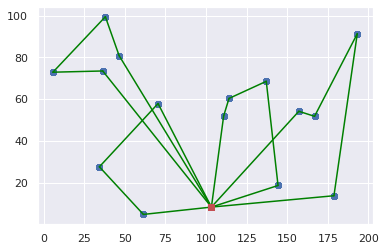

In [20]:
#model parameters
N_PATIENTS = 15
VEHICLE_CAPACITY = 4
TIME_LIMIT = 10
SEED = 101

#create a problem instance
instance = problem_instance(N_PATIENTS, VEHICLE_CAPACITY, random_state=SEED)

#create an instance of a gurobi optimisation model
model, x, u = optimisation_model(instance)

#limit run time?
if TIME_LIMIT > -1:
    model.Params.TimeLimit = TIME_LIMIT  

#execute the optimisation procedure
model.optimize()

#show the routes
plot_solution(x, instance)